# Auswertung mit ganzen ID5 Files 15.06.2022

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy.optimize import curve_fit
# Formel für die Regression
def lin (a, x, b):
    return a * x + b
import seaborn as sns
def set_ticksStyle(x_size=30, y_size=30, x_dir='in', y_dir='in'):
    sns.set_style('ticks', {'xtick.major.size': x_size, 'ytick.major.size': y_size, 'xtick.direction': x_dir, 'ytick.direction': y_dir})

Hier erstell ich eine Liste mit allen möglichen Well identifier. Die braucht man später bei der Melt Funktion in Pandas

In [2]:
letter=["A","B","C","D","E","F","G","H"]
plate = []
for l in letter:
    for i in range(1,13):
        plate.append(l+str(i))
        
print(plate)

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12']


### Einlesen und Datenverarbeitung
Hier passiert die ganze Magie. Mit `with open`kann eine Datei geöffnet werden. Dann werden die Zeilen gelesen solange diese nicht leer sind. Mit den Bedingungen kann dann zwischen Messung und Meta und Ende gefiltert werden. Wenn ein `~End` kommt werden die Dataframes gebaut und in ein Dictionary gespeichert. Danach wird alles initialisiert und die nächste Runde geht los. Details in den Kommentaren.

In [3]:
# Initialisieren aller Variablen
meta = []
data = []
cols = []
data_dict = {}
iterator = 0
# Öffnen der CSV Datei
with open('data/test_measure.txt', 'r') as reader:
    # Read and print the entire file line by line
    # Hier wird die erste Zeile gelesen
    line = reader.readline()
    # Hier werden die Metadaten rein geladen für die aller erste Zeile nur. line.split() erstellt eine Liste mit allen Elementen zwischen den ;
    meta = line.split("\t")
    # Alles was in der Liste leer ist wird rausgelöscht
    meta = list(filter(None, meta))
    # Nun gehen wir Zeilenweise durch die Datei bis diese leer ist
    while line !="":
        # Hier wird wieder eine Zeile gelesen
        line = reader.readline()
        #print(line)
        # Umbrüche werden weggelöscht
        line = line.strip('\n')
        #print(line)
        # Wenn die Zeile mit ~End starte, wird das vorher gelesene Zeug verarbeitet
        if line.startswith("~End"):
            # Aus einer Liste wird ein Dataframe mit den gelesenen Spaltennamen
            df = pd.DataFrame(data, columns=cols)
            # Erste Zeile des Dataframes wird gelöscht, da hier die Spaltennamen stehen
            df = df.iloc[1: , :]
            # Leere Spalten werden durch NaN ersetzt
            df = df.replace("", np.nan)
            # Spalten die NaN ausweisen werden entfernt
            df = df.dropna(axis=1, how="any")
            #print(df)
            # Nun wird die Tabelle geschmolzen. Heißt die Wellnummern werden der Wavelength und der Temperatur zugeordet. Mit list(set(plate).intersection(df.columns)) werden nur die Wellnummern gefilter die es auch wirklich gibt
            df = df.melt(id_vars = df.columns[:2],value_vars= list(set(plate).intersection(df.columns)))
            # Dataframe wird dem Dictionary zugeordnet duch einen Iterator. Die erste verabreitete Messung ist dann Messung 0 usw.
            data_dict[f"Messung{iterator}"] = df
            data_dict[f"Metadaten{iterator}"] = meta
            #df.to_csv(f"Messung{iterator}.csv",index=False)
            # Reinitialisieren für den nächsten durchgang
            meta = list()
            data = list()
            cols = list()
            iterator += 1
            df.empty
        # Metadaten werden ausgelesen. Wie oben. Der obere Befehl gilt nur für die erste Zeile in der Datei
        elif line.startswith("Plate"):
            meta = line.split("\t")
            meta = list(filter(None, meta))
        # Hier werden die Spaltennamen als Liste gespeichert. Das braucht man um den Dataframe anzulegen
        elif line.startswith("Wavelength"):
            cols = line.split("\t")
            #print(cols)
        # Wenn kein Plate oder ~End oder nichts steht werden Daten in eine Liste geschrieben die später zum DataFrame gebaut werden
        elif any(line.split("\t")) != False and line.split("\t")[0] != "Plate:" and line.split("\t")[0] != "~End" and line.split("\t")[0] != "Wavelength:":
            hlp = line.split("\t")
            #print(hlp)
            data.append(hlp)

### Zugriff auf die Daten im Dictionary
Im data_dict stehen nun alle Daten aus der Datei. Jetzt kann jede Messung einzeln angesteuert werden.

In [4]:
print(data_dict.keys())

dict_keys(['Messung0', 'Metadaten0', 'Messung1', 'Metadaten1', 'Messung2', 'Metadaten2', 'Messung3', 'Metadaten3'])


In [5]:
def unique(list1):
  
    # initialize a null list
    unique_list = []
      
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print (x)

Messung_1 = data_dict["Messung0"]
print(data_dict["Metadaten0"])
print(unique(Messung_1["variable"]))
#m_F_517_470 = Messung[(Messung.loc[:,'Farbstoff'] == "Fluorescein") & (Messung.loc[:,('Em')] == 517)]
MA1 = Messung_1[(Messung_1.loc[:,'variable'] == 'A1')]
MA2 = Messung_1[(Messung_1.loc[:,'variable'] == 'A2')]
MB1 = Messung_1[(Messung_1.loc[:,'variable'] == 'B1')]
MC1 = Messung_1[(Messung_1.loc[:,'variable'] == 'C1')]

['Plate:', 'Cy3_em', '1.3', 'TimeFormat', 'Spectrum', 'Fluorescence', 'FALSE', 'Raw', 'FALSE', '76', '500', '650', '2', '1', '1', '96', 'Manual', 'Emission Sweep', '480', '6', 'Automatic', '1', '3', '\n']
A2
A1
B1
C1
None


Text(0, 0.5, 'RFU')

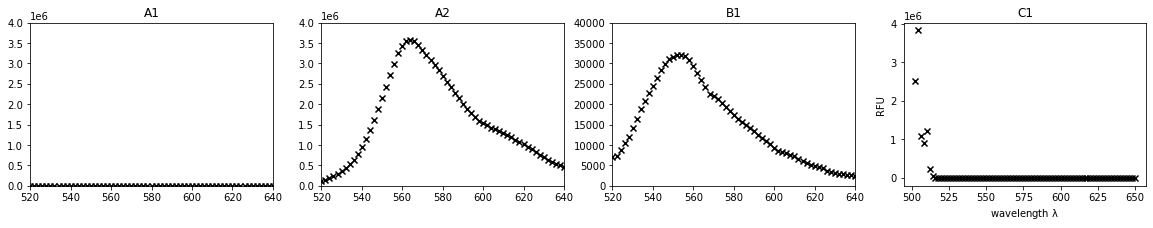

In [6]:


f, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 3), sharex=False, sharey=False, squeeze=False)
ax[0,0].scatter([float(i) for i in MA1["Wavelength"]] ,[float(i) for i in MA1["value"]], marker="x", color="black")
ax[0,0].set_title("A1")
ax[0,0].set_xlim([520,640])
ax[0,0].set_ylim([0,4000000])

ax[0,1].scatter([float(i) for i in MA2["Wavelength"]] ,[float(i) for i in MA2["value"]], marker="x", color="black")
ax[0,1].set_title("A2")
ax[0,1].set_xlim([520,640])
ax[0,1].set_ylim([0,4000000])

ax[0,2].scatter([float(i) for i in MB1["Wavelength"]] ,[float(i) for i in MB1["value"]], marker="x", color="black")
ax[0,2].set_title("B1")
ax[0,2].set_xlim([520,640])
ax[0,2].set_ylim([0,40000])

ax[0,3].scatter([float(i) for i in MC1["Wavelength"]] ,[float(i) for i in MC1["value"]], marker="x", color="black")
ax[0,3].set_title("C1")
#ax[0,3].set_xlim([600,650])
#ax[0,3].set_ylim([0,40000])

plt.xlabel(r'wavelength $\mathregular{\lambda}$')
plt.ylabel("RFU")
     